# Importing Libraries

In [149]:
import io
import re
import time
import zipfile
import unicodedata
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Loading Dataset

In [83]:
!wget http://www.manythings.org/anki/fra-eng.zip -O /tmp/fra-eng.zip

--2020-07-02 05:33:25--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 172.67.173.198, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6041598 (5.8M) [application/zip]
Saving to: ‘/tmp/fra-eng.zip’

/tmp/fra-eng.zip    100%[===================>]   5.76M  8.35MB/s    in 0.7s    

2020-07-02 05:33:26 (8.35 MB/s) - ‘/tmp/fra-eng.zip’ saved [6041598/6041598]



In [84]:
local_training_zip = '/tmp/fra-eng.zip'
if zipfile.is_zipfile(filename=local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
    zip_ref.extractall(path='/tmp/')
    zip_ref.close()

In [85]:
PATH_TO_FILE = '/tmp/fra.txt'

# Preparing Dataset

In [86]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [87]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    return w

In [88]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1]]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [89]:
en, fr = create_dataset(PATH_TO_FILE, None)

In [90]:
def unique_words(data):
    tmp, mx = [], -1
    for i in data:
        lst = i.split()
        tmp.extend(lst)
        mx = max(len(lst), mx)
    return list(set(tmp)), mx

In [91]:
u_en, mx_en = unique_words(data=en)
print('No. of unique words in en:', len(u_en))
print('Max-length of sentences:', mx_en, end='\n\n')

u_fr, mx_fr = unique_words(data=en)
print('No. of unique words in fr:', len(u_fr))
print('Max-length of sentences:', mx_fr)

No. of unique words in en: 14009
Max-length of sentences: 53

No. of unique words in fr: 14009
Max-length of sentences: 53


In [92]:
EN_VOCAB_SIZE = 50
FR_VOCAB_SIZE = 50

In [93]:
def tokenize(data, num_words):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=num_words,
        filters='',
        lower=True,
        split=' ',
        char_level=False,
        oov_token=None
    )
    tokenizer.fit_on_texts(texts=data)
    
    return tokenizer

In [94]:
en_tokenizer = tokenize(data=en, num_words=EN_VOCAB_SIZE)
fr_tokenizer = tokenize(data=fr, num_words=FR_VOCAB_SIZE)

In [95]:
print('English => index-to-word:')
for i in range(1, 10):
    print(i, '--> ' + en_tokenizer.index_word[i])

print('\nFrench => index-to-word:')
for i in range(1, 10):
    print(i, '--> ' + fr_tokenizer.index_word[i])

English => index-to-word:
1 --> <start>
2 --> <end>
3 --> .
4 --> i
5 --> you
6 --> to
7 --> the
8 --> ?
9 --> a

French => index-to-word:
1 --> <start>
2 --> <end>
3 --> .
4 --> je
5 --> a
6 --> de
7 --> ?
8 --> pas
9 --> est


In [96]:
print('English => word-to-index:')
for i in range(1, 10):
    print(list(en_tokenizer.word_index)[i] + ' -->', i)

print('\nFrench => index-to-word:')
for i in range(1, 10):
    print(list(fr_tokenizer.word_index)[i] + ' -->', i)

English => word-to-index:
<end> --> 1
. --> 2
i --> 3
you --> 4
to --> 5
the --> 6
? --> 7
a --> 8
t --> 9

French => index-to-word:
<end> --> 1
. --> 2
je --> 3
a --> 4
de --> 5
? --> 6
pas --> 7
est --> 8
vous --> 9


In [97]:
print('English => word-counts:')
for i in range(1, 10):
    print(list(en_tokenizer.word_counts.keys())[i] + ' -->', list(en_tokenizer.word_counts.values())[i])

print('\nFrench => word-counts:')
for i in range(1, 10):
    print(list(fr_tokenizer.word_counts.keys())[i] + ' -->', list(fr_tokenizer.word_counts.values())[i])

English => word-counts:
go --> 4303
. --> 148329
<end> --> 177210
hi --> 19
run --> 298
! --> 1298
who --> 2469
? --> 29358
wow --> 12

French => word-counts:
va --> 1466
! --> 5591
<end> --> 177210
salut --> 19
. --> 143871
cours --> 227
courez --> 11
qui --> 4792
? --> 29378


In [98]:
en_sequences = en_tokenizer.texts_to_sequences(texts=en)
fr_sequences_in = fr_tokenizer.texts_to_sequences(texts=fr)
fr_sequences_out = [seq[1:] for seq in fr_sequences_in]

In [99]:
def pad(data, pad_maxlen, pad_type, trunc_type):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences=data, maxlen=pad_maxlen, padding=pad_type, truncating=trunc_type, value=0.0)

In [100]:
en_pad_sequences = pad(data=en_sequences, pad_maxlen=mx_en, pad_type='pre', trunc_type='pre')
fr_pad_sequences_in = pad(data=fr_sequences_in, pad_maxlen=mx_fr, pad_type='post', trunc_type='post')
fr_pad_sequences_out = pad(data=fr_sequences_out, pad_maxlen=mx_fr, pad_type='post', trunc_type='post')

In [101]:
print(en_pad_sequences.shape)
print(fr_pad_sequences_in.shape)
print(fr_pad_sequences_out.shape)

(177210, 53)
(177210, 53)
(177210, 53)


In [102]:
NUM_EPOCHS = 10
BATCH_SIZE = 30
assert en_pad_sequences.shape[0]%BATCH_SIZE == 0
TRAIN_BATCH_SIZE = en_pad_sequences.shape[0]//BATCH_SIZE

In [103]:
dataset = tf.data.Dataset.from_tensor_slices((en_pad_sequences, fr_pad_sequences_in, fr_pad_sequences_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

In [104]:
EMBEDDING_SIZE = 100
LSTM_SIZE = 10

# Approaches

+ https://cedar.buffalo.edu/~srihari/CSE676/12.4.6%20AttentionModels.pdf

## Seq2Seq Model

![Seq2Seq](https://machinetalk.org/wp-content/uploads/2019/04/input.png)

----

![Teacher Forcing](https://miro.medium.com/max/842/1*U3d8D_GnfW13Y3nDgvwJSw.png)

In [105]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__(name='Encoder')

        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        # state_h, state_c
        return (tf.zeros([batch_size, self.lstm_size]), tf.zeros([batch_size, self.lstm_size]))

In [106]:
encoder = Encoder(vocab_size=EN_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, lstm_size=LSTM_SIZE)

In [107]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Decoder, self).__init__(name='Decoder')

        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(units=vocab_size)

    def call(self, sequence, state):
        embed = self.embedding(sequence)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        logits = self.dense(lstm_out)
        return logits, state_h, state_c

In [108]:
decoder = Decoder(vocab_size=FR_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, lstm_size=LSTM_SIZE)

In [109]:
# ignoring padded zeroes
def loss_func(targets, logits):
    # The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits.
    # In other words, the softmax function has not benn applied on them to produce a probability distribution.
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(targets, 0)), dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [110]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

In [111]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, enc_obj, dec_obj, enc_initial_states):
    with tf.GradientTape() as tape:
        en_outputs = enc_obj(source_seq, enc_initial_states)
        en_states = en_outputs[1:]
        de_states = en_states

        de_outputs = dec_obj(target_seq_in, de_states)
        logits = de_outputs[0]
        loss = loss_func(target_seq_out, logits)

    variables = enc_obj.trainable_variables + dec_obj.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [112]:
losses = []
for e in range(NUM_EPOCHS):
    start = time.time()
    enc_initial_states = encoder.init_states(BATCH_SIZE)

    for batch, (source_seq, target_seq_in, target_seq_out) in tqdm(enumerate(dataset.take(-1)), desc='Epoch - '+str(e+1), total=TRAIN_BATCH_SIZE):
        loss = train_step(source_seq, target_seq_in, target_seq_out, encoder, decoder, enc_initial_states)

    losses.append(loss)
    end = time.time()

    print('Epoch: {} \t Loss: {:.9f} \t Time: {:.9f}'.format(e + 1, loss.numpy(), end-start))


Epoch: 1 	 Loss: 1.021622181 	 Time: 41.474488020



Epoch: 2 	 Loss: 1.015831470 	 Time: 39.423503399



Epoch: 3 	 Loss: 0.994951606 	 Time: 39.003308773



Epoch: 4 	 Loss: 0.995192826 	 Time: 38.800112247



Epoch: 5 	 Loss: 1.041716695 	 Time: 38.791987896



Epoch: 6 	 Loss: 1.029605627 	 Time: 38.612705708



Epoch: 7 	 Loss: 1.011270046 	 Time: 38.988921642



Epoch: 8 	 Loss: 0.978200912 	 Time: 38.574026346



Epoch: 9 	 Loss: 0.985192418 	 Time: 38.728305817



Epoch: 10 	 Loss: 0.976052582 	 Time: 39.182327271


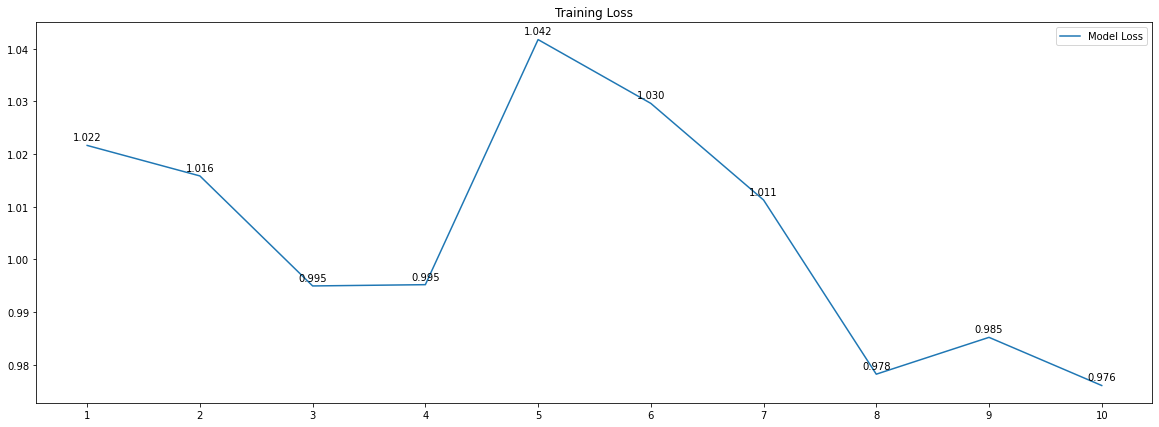

In [113]:
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(20, 7))
plt.plot(epochs, losses, label='Model Loss', )
plt.legend()
plt.title('Training Loss')
plt.xticks(epochs)
for x, y in zip(epochs, losses):
    label = "{:.3f}".format(y)
    plt.annotate(label,                               # this is the text
                (x, y),                              # this is the point to label
                textcoords="offset points",          # how to position the text
                xytext=(0, 5),                       # distance from text to points (x,y)
                ha='center')                         # horizontal alignment can be left, right or center

In [114]:
def predict(lang1, lang2, num, tokenizer1, tokenizer2):
    for _ in range(num):
        index = np.random.choice(len(lang1))
        test_source_text = lang1[index]
        print(test_source_text)

        test_source_seq = tokenizer1.texts_to_sequences([test_source_text])
        test_source_pad_seq = pad(test_source_seq, mx_en, 'pre', 'pre')

        en_initial_states = encoder.init_states(1)
        en_outputs = encoder(tf.constant(test_source_pad_seq), en_initial_states)

        de_input = tf.constant([[tokenizer2.word_index['<start>']]])
        de_state_h, de_state_c = en_outputs[1:]
        out_words = []

        while True:
            de_output, de_state_h, de_state_c = decoder(de_input, (de_state_h, de_state_c))
            de_input = tf.argmax(de_output, -1)
            out_words.append(tokenizer2.index_word[de_input.numpy()[0][0]])

            if out_words[-1] == '<end>' or len(out_words) >= 20:
                break

        print(' '.join(out_words))

        print(lang2[index], end='\n\n')

In [115]:
predict(lang1=en, lang2=fr, num=5, tokenizer1=en_tokenizer, tokenizer2=fr_tokenizer)

<start> the leaves on trees have turned red . <end>
le de de la de . <end>
<start> les feuilles sur les arbres ont vire au rouge . <end>

<start> i need you right now . <end>
je que vous . <end>
<start> j ai immediatement besoin de toi . <end>

<start> the moon has come out . <end>
les de la de . <end>
<start> la lune est apparue . <end>

<start> thank you for your answer . <end>
vous de de . <end>
<start> merci de ta reponse . <end>

<start> i really hope things work out for you . <end>
je que vous . <end>
<start> j espere vraiment que les choses marchent pour vous . <end>



## Seq2Seq with Attention Model

![Attention Model](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

---

![Attention Equations](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)

![Scores](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)

---

+ **Luong Attention Score**
<br/>

![Luong Attention Score](https://machinetalk.org/wp-content/uploads/2019/03/score_eq-455x111.png)

---

Here’s the key differences between the two:

+ Bahdanau attention mechanism proposed only the concat score function.
+ Luong-style attention uses the current decoder output to compute the alignment vector, whereas Bahdanau’s uses the output of the previous time step.

In [116]:
class AttentionEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size):
        super(AttentionEncoder, self).__init__(name='AttentionEncoder')
        self.rnn_size = rnn_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.compat.v1.keras.layers.CuDNNLSTM(units=rnn_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.rnn_size]), tf.zeros([batch_size, self.rnn_size]))

In [117]:
encoder = AttentionEncoder(vocab_size=EN_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, rnn_size=LSTM_SIZE)

In [118]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__(name='LuongAttention')
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError('Unknown attention score function! Must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(units=rnn_size)

        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(units=rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(units=1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True)

        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)

        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(decoder_output, [1, encoder_output.shape[1], 1])

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1])

        # alignment a_t = softmax(score) => Attention weights
        alignment = tf.nn.softmax(score, axis=2)

        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output)

        return context, alignment

In [119]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, rnn_size):
        super(BahdanauAttention, self).__init__(name='BahdanauAttention')
        self.W1 = tf.keras.layers.Dense(units=rnn_size)
        self.W2 = tf.keras.layers.Dense(units=rnn_size)
        self.V = tf.keras.layers.Dense(units=1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [120]:
class AttentionDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size, attention_type, attention_func):
        super(AttentionDecoder, self).__init__(name='AttentionDecoder')

        if attention_type:
            self.attention = LuongAttention(rnn_size, attention_func)
        else:
            self.attention = BahdanauAttention(rnn_size)
        self.rnn_size = rnn_size

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.compat.v1.keras.layers.CuDNNLSTM(units=rnn_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(units=rnn_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(units=vocab_size)

    def call(self, sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, rnn_size)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, rnn_size),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * rnn_size)
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, rnn_size)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [121]:
decoder = AttentionDecoder(vocab_size=FR_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, rnn_size=LSTM_SIZE, attention_type=True, attention_func='concat')

In [122]:
# ignoring padded zeroes
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(targets, 0)), dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [123]:
optimizer = tf.keras.optimizers.Adam()

In [124]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, enc_obj, dec_obj, enc_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = enc_obj(source_seq, enc_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    variables = enc_obj.trainable_variables + dec_obj.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [125]:
attention_losses = []
for e in range(NUM_EPOCHS):
    start = time.time()
    enc_initial_states = encoder.init_states(BATCH_SIZE)

    for batch, (source_seq, target_seq_in, target_seq_out) in tqdm(enumerate(dataset.take(-1)), desc='Epoch - '+str(e+1), total=TRAIN_BATCH_SIZE):
        loss = train_step(source_seq, target_seq_in, target_seq_out, encoder, decoder, enc_initial_states)

    attention_losses.append(loss)
    end = time.time()

    print('Epoch: {} \t Loss: {:.9f} \t Time: {:.9f}'.format(e + 1, loss.numpy(), end-start))


Epoch: 1 	 Loss: 1.015405297 	 Time: 538.736631155



Epoch: 2 	 Loss: 0.983329952 	 Time: 421.039797306



Epoch: 3 	 Loss: 1.025039315 	 Time: 421.625010729



Epoch: 4 	 Loss: 0.986244202 	 Time: 421.928465366



Epoch: 5 	 Loss: 1.010957599 	 Time: 422.772324800



Epoch: 6 	 Loss: 0.942202866 	 Time: 422.038801908



Epoch: 7 	 Loss: 0.991358936 	 Time: 422.499272823



Epoch: 8 	 Loss: 0.959024787 	 Time: 422.838549614



Epoch: 9 	 Loss: 0.980504155 	 Time: 420.838910580



Epoch: 10 	 Loss: 0.999476016 	 Time: 428.885845661


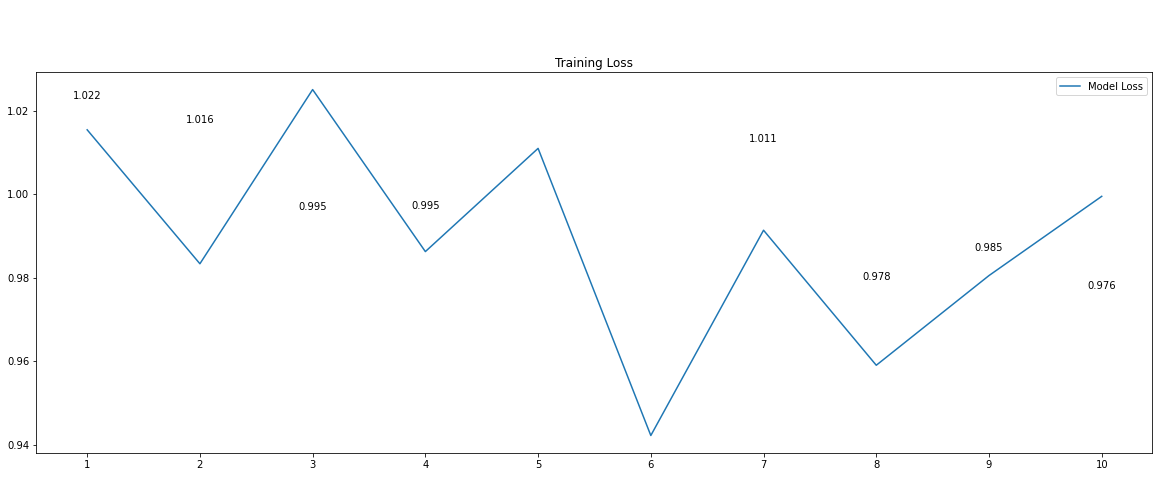

In [132]:
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(20, 7))
plt.plot(epochs, attention_losses, label='Model Loss', )
plt.legend()
plt.title('Training Loss')
plt.xticks(epochs)
for x, y in zip(epochs, losses):
    label = "{:.3f}".format(y)
    plt.annotate(label,                               # this is the text
                (x, y),                              # this is the point to label
                textcoords="offset points",          # how to position the text
                xytext=(0, 5),                       # distance from text to points (x,y)
                ha='center')                         # horizontal alignment can be left, right or center

In [142]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [147]:
def attentionPredict(lang1, lang2, num, tokenizer1, tokenizer2):
    for _ in range(num):
        index = np.random.choice(len(lang1))
        test_source_text = lang1[index]
        print(test_source_text)

        test_source_seq = tokenizer1.texts_to_sequences([test_source_text])
        # test_source_pad_seq = pad(test_source_seq, mx_en, 'pre', 'pre')

        en_initial_states = encoder.init_states(1)
        # en_outputs = encoder(tf.constant(test_source_pad_seq), en_initial_states)
        en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

        de_input = tf.constant([[tokenizer2.word_index['<start>']]])
        de_state_h, de_state_c = en_outputs[1:]
        out_words, alignments = [], []

        while True:
            de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
            de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
            out_words.append(tokenizer2.index_word[de_input.numpy()[0][0]])
            alignments.append(tf.reshape(alignment, (-1, )).numpy())

            if out_words[-1] == '<end>' or len(out_words) >= 20:
                break

        print(' '.join(out_words))

        print(lang2[index], end='\n\n')
        
        plot_attention(attention=alignments, sentence=test_source_text.split(), predicted_sentence=lang2[index].split())

<start> i felt like crying . <end>
j ai la de la . <end>
<start> j avais envie de pleurer . <end>

<start> i will go along with you as far as the station . <end>
j ai de la de la . <end>
<start> je vais t accompagner jusqu a la gare . <end>

<start> i ll be praying for you . <end>
je que vous de . <end>
<start> je prierai pour toi . <end>

<start> what is all that stuff ? <end>
que vous ? j ai de . <end>
<start> c est quoi , tous ces trucs ? <end>

<start> they are engaged in cancer research . <end>
de ai de de la . <end>
<start> ils se sont impliques dans la recherche sur le cancer . <end>



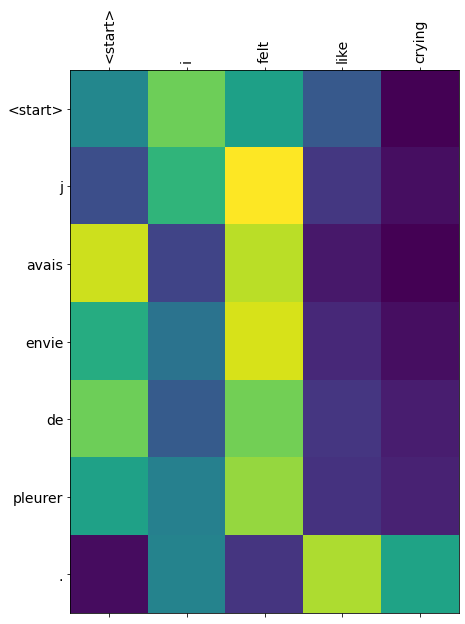

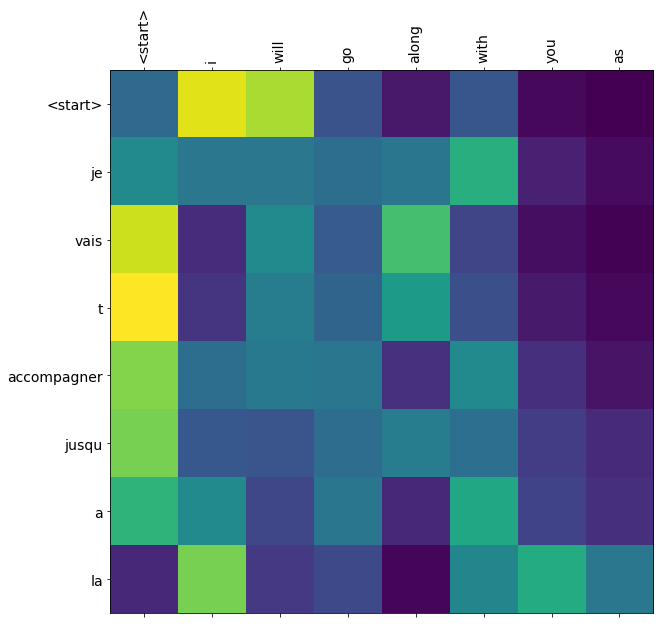

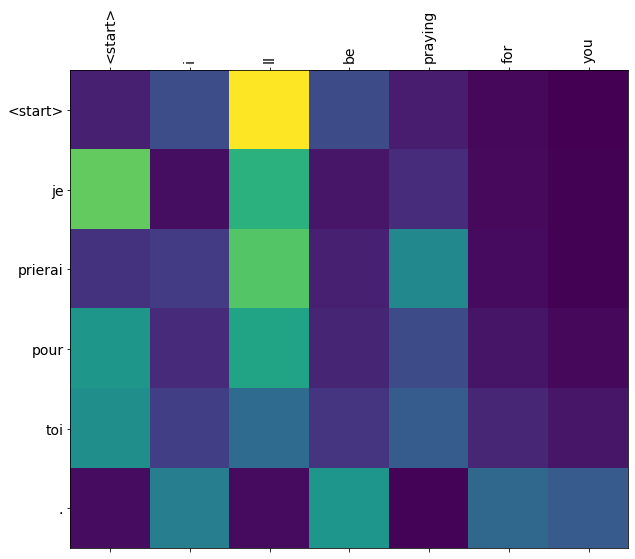

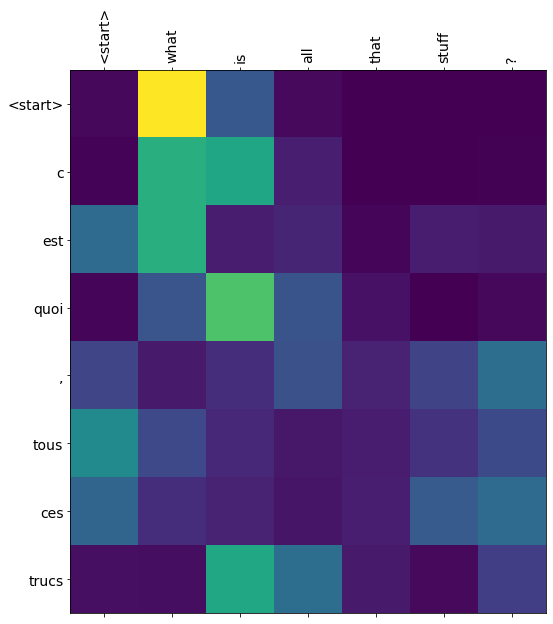

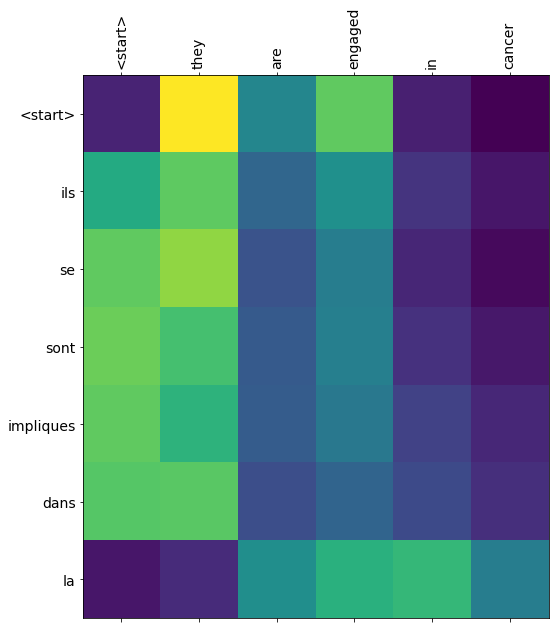

In [150]:
attentionPredict(lang1=en, lang2=fr, num=5, tokenizer1=en_tokenizer, tokenizer2=fr_tokenizer)